In [ ]:
from google.colab import drive; drive.mount('/content/drive')   # OK to enable, if kaggle.json is stored in Google Drive

Mounted at /content/drive


In [ ]:
!pip -q install scikit-learn -U > log
!pip -q install tensorflow==2.7 >> log
!apt -q install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2 >> log
!pip -q install -U tfds-nightly tensorflow_addons tensorflow >> log

In [ ]:
!pip -q install --upgrade --force-reinstall --no-deps kaggle > log  # upgrade kaggle package (to avoid a warning)
!mkdir -p ~/.kaggle                               # .kaggle folder must contain kaggle.json for kaggle executable to properly authenticate you to Kaggle.com
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json >log  # First, download kaggle.json from kaggle.com (in Account page) and place it in the root of mounted Google Drive
!cp kaggle.json ~/.kaggle/kaggle.json > log       # Alternative location of kaggle.json (without a connection to Google Drive)
!chmod 600 ~/.kaggle/kaggle.json                  # give only the owner full read/write access to kaggle.json
!kaggle config set -n competition -v 5dec22venus-vs-mars # set the competition context for the next few kaggle API calls. !kaggle config view - shows current settings
!kaggle competitions download >> log              # download competition dataset as a zip file
!unzip -o *.zip >> log                            # Kaggle dataset is copied as a single file and needs to be unzipped.
!kaggle competitions leaderboard --show           # print public leaderboard

cp: cannot stat '/content/drive/MyDrive/kaggle.json': No such file or directory
- competition is now set to: 5dec22venus-vs-mars
Using competition: 5dec22venus-vs-mars
 teamId  teamName             submissionDate       score    
-------  -------------------  -------------------  -------  
9564274  🪐Baseline in Python  2022-08-02 11:11:07  0.40120  


See [more](https://nvidia.custhelp.com/app/answers/detail/a_id/3751/~/useful-nvidia-smi-queries) about NVIDIA GPU stats. Test your code in (free) Colab. It uses Tesla K80 GPU.

In [ ]:
!nvidia-smi --query-gpu=gpu_name,memory.total,memory.free,memory.used --format=csv

name, memory.total [MiB], memory.free [MiB], memory.used [MiB]
Tesla T4, 15109 MiB, 12219 MiB, 2890 MiB


In [ ]:
%%time
%%capture
%reset -f
!pip -q install -U tensorflow_addons plotly > log   # update tfa in case students need to use it
from IPython.core.interactiveshell import InteractiveShell as IS; IS.ast_node_interactivity = "all" 
import numpy as np, pandas as pd, time, matplotlib.pyplot as plt, os
# os.environ['TF_DETERMINISTIC_OPS'] = '1'  # causes an error   https://github.com/tensorflow/tensorflow/issues/38197
import tensorflow_addons as tfa, tensorflow as tf, tensorflow.keras as keras, tensorflow_datasets as tfds
from keras.layers import Flatten, Dense, Dropout, MaxPooling2D, Conv2D, GlobalAveragePooling2D
from keras.models import Sequential
from tensorflow.keras.applications import resnet50, xception, mobilenet, mobilenet_v2, mobilenet_v3
from tensorflow.keras.utils import image_dataset_from_directory as idfd
ToCSV = lambda df, fname: df.round(2).to_csv(f'{fname}.csv', index_label='id') # rounds values to 2 decimals

class Timer():
  def __init__(self, lim:'RunTimeLimit'=60*5): self.t0, self.lim, _ = time.time(), lim, print(f'⏳ started. You have {lim} sec. Good luck!')
  def ShowTime(self):
    msg = f'Runtime is {time.time()-self.t0:.0f} sec'
    print(f'\033[91m\033[1m' + msg + f' > {self.lim} sec limit!!!\033[0m' if (time.time()-self.t0-1) > self.lim else msg)

np.set_printoptions(linewidth=100, precision=2, edgeitems=5, suppress=True)
pd.set_option('max_columns', 20, 'precision', 2, 'display.max_rows', 4)
tDIR, sDIR = '/content/drive/MyDrive/5dec22venus-vs-mars/train/', '/content/drive/MyDrive/5dec22venus-vs-mars/test/'

CPU times: user 587 ms, sys: 110 ms, total: 698 ms
Wall time: 25.9 s


Examples of images from female class

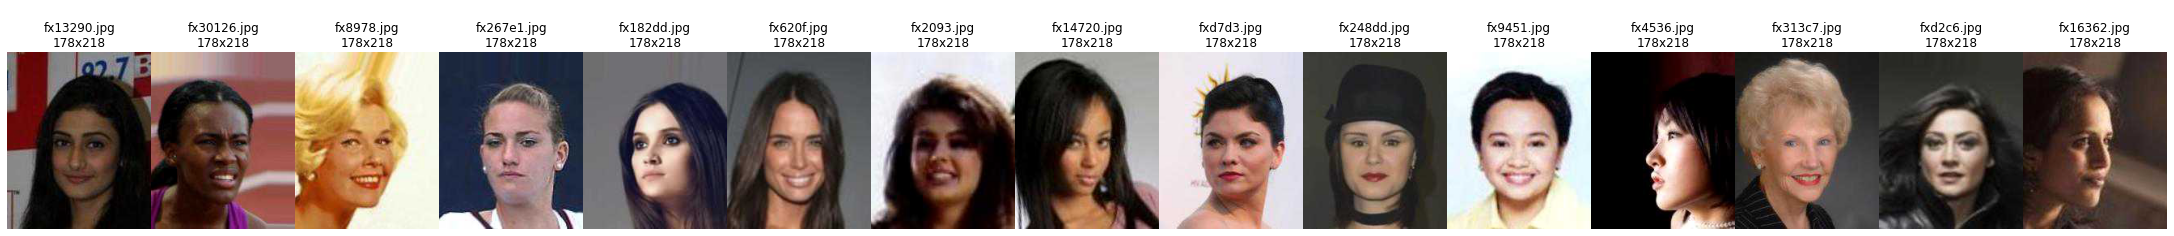

In [ ]:
n, fig = 15, plt.figure(figsize=(30,10));
for i, f in enumerate(np.random.RandomState(0).choice(os.listdir(tDIR+'female/'), n)):
  ax = plt.subplot(1, n, i + 1)
  img = keras.preprocessing.image.load_img(tDIR+'female/'+f);
  _ = ax.set_title(f'\n{f}\n{img.size[0]}x{img.size[1]}');
  _ = plt.axis('off');   _ = plt.tight_layout(pad=0);   _ = plt.imshow(img);

Examples of images from male class

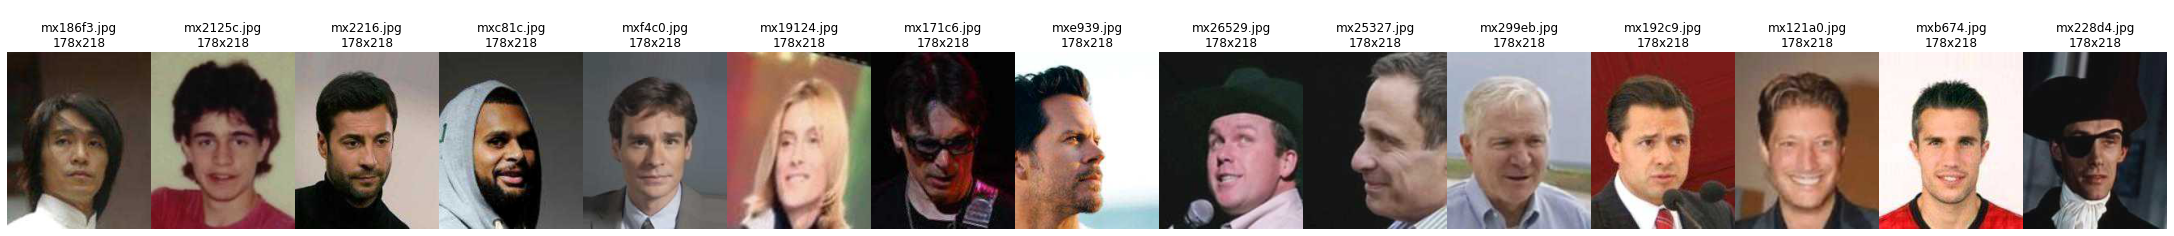

In [ ]:
n, fig = 15, plt.figure(figsize=(30,10));
for i, f in enumerate(np.random.RandomState(0).choice(os.listdir(tDIR+'male/'), n)):
  ax = plt.subplot(1, n, i + 1)
  img = keras.preprocessing.image.load_img(tDIR+'male/'+f);
  _ = ax.set_title(f'\n{f}\n{img.size[0]}x{img.size[1]}');
  _ = plt.axis('off');   _ = plt.tight_layout(pad=0);   _ = plt.imshow(img);

In [ ]:
tmr = Timer() # runtime limit (in seconds). Add all of your code after the timer

⏳ started. You have 300 sec. Good luck!


<font size=5>⏳</font> <strong><font color=orange size=5>Your Code, Documentation, Ideas and Timer - All Start Here...</font></strong>


## **Task 2.1**

**Explain your preprocessing:** i.e. feature engineering, subsampling, clustering, dimensionality reduction, etc.

Препроцессинг не производился

## **Task 2.2**

**Explain your modeling approach:** ideas you tried and why you thought they would be helpful. Takeaway: how these decisions guided you in modeling.

Были испробованы разные модели заранее обученных сетей:

inception_resnet_v2

inception_v3

efficientnet_v2

vgg16

vgg19 

Наилучшее соотношение времени выполнения и точности показала сеть efficientnet_v2

EfficientNetV2 - новое семейство конволюционных сетей, обладающих более высокой скоростью обучения и лучшей эффективностью параметров, чем предыдущие модели. Для разработки этого семейства моделей использована комбинация поиска нейронной архитектуры с учетом обучения и масштабирования для совместной оптимизации скорости обучения и эффективности параметров. Модели были найдены из пространства поиска, обогащенного новыми операциями, такими как Fused-MBConv. 


The following cell loads train/validation/test sets as [TF datasets](https://www.tensorflow.org/datasets), `tDS`, `vDS` and `sDS`, respectively.

In [ ]:
BS, image_size = 32, (224, 224)  # batch size; image dimensions required by pretrained model
tDS = idfd( tDIR, labels='inferred', label_mode='binary', subset='training', validation_split=0.2,
           class_names=None, color_mode='rgb', batch_size=BS, image_size=image_size, shuffle=True, seed=0).prefetch(buffer_size=tf.data.AUTOTUNE)  # training dataset
vDS = idfd( tDIR, labels='inferred', label_mode='binary', subset='validation', validation_split=0.2,
           class_names=None, color_mode='rgb', batch_size=BS, image_size=image_size, shuffle=True, seed=0).prefetch(buffer_size=tf.data.AUTOTUNE)  # validation dataset
sDS = idfd( sDIR, labels=None, label_mode='binary', subset=None, validation_split=None,
           class_names=None, color_mode='rgb', batch_size=BS, image_size=image_size, shuffle=False, seed=0)           # don't prefetch this testing dataset
print(tf.reduce_sum([tf.reduce_sum(f) for f in list(tDS.take(1))[0][0][:10]])) # to validate seeding of file sampling

Found 5000 files belonging to 2 classes.
Using 4000 files for training.
Found 5000 files belonging to 2 classes.
Using 1000 files for validation.
Found 5000 files belonging to 1 classes.
tf.Tensor(147468820.0, shape=(), dtype=float32)


This is your baseline DNN model. Remember to [seed all your experiments](https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development) for reproducibility. [Status of GPU-Determinism in TF](https://github.com/NVIDIA/framework-determinism/blob/master/tensorflow_status.md). 

Below we replace the top layer of the pretrained CNN ([MobileNetV2](https://openaccess.thecvf.com/content_cvpr_2018/papers/Sandler_MobileNetV2_Inverted_Residuals_CVPR_2018_paper.pdf)) and train the new layer only (all remaining pretrained layers are frozen).

In [ ]:
from tensorflow.keras.applications import inception_resnet_v2,inception_v3,efficientnet_v2

In [ ]:
%%time
tf.random.set_seed(0)   # always seed your experiments
Init = keras.initializers.RandomNormal(seed=0) # seed all that you can

pm = efficientnet_v2.EfficientNetV2S(weights="imagenet", include_top=False)  # pretrained Xception model
avg = GlobalAveragePooling2D(data_format='channels_last')(pm.output)  # collapse spatial dimensions
output = Dense(1, activation="sigmoid", kernel_initializer=Init)(avg)
pm1 = keras.Model(inputs=pm.input, outputs=output)
for l in pm.layers: l.trainable = False                               # freeze layers from training

# optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)  # legacy definition
lrs = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=.2, decay_steps=10000, decay_rate=0.01)
opt = keras.optimizers.SGD(learning_rate=lrs, momentum=0.9)
pm1.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
hist = pm1.fit(tDS, epochs=2, validation_data=vDS)     # For BS=32, 2xCPU: 15min/epoch, GPU: 15sec/epoch  (60x faster)

219055592/219055592 [==============================] - 10s 0us/step
Epoch 1/2
125/125 [==============================] - 44s 253ms/step - loss: 1139332.5000 - accuracy: 0.5185 - val_loss: 259085.5781 - val_accuracy: 0.5840
Epoch 2/2
125/125 [==============================] - 29s 225ms/step - loss: 795972.1875 - accuracy: 0.5117 - val_loss: 514489.0938 - val_accuracy: 0.5860
CPU times: user 54.8 s, sys: 5.23 s, total: 1min
Wall time: 1min 28s


Below we post-train all pre-trained layers after unlocking them.

In [ ]:
%%time
for l in pm.layers: l.trainable = True      # allow training
# opt = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, decay=0.001)  # legacy definition
lrs = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=.01, decay_steps=10000, decay_rate=0.001)
opt = keras.optimizers.SGD(learning_rate=lrs, momentum=0.9)
pm1.compile(loss="binary_crossentropy", optimizer=opt, metrics=['binary_accuracy'])
hist = pm1.fit(tDS, epochs=2, validation_data=vDS)

Epoch 1/2
125/125 [==============================] - 114s 620ms/step - loss: 194.7574 - binary_accuracy: 0.5075 - val_loss: 1354170499072.0000 - val_binary_accuracy: 0.5860
Epoch 2/2
125/125 [==============================] - 76s 607ms/step - loss: 19.0407 - binary_accuracy: 0.5130 - val_loss: 876481216.0000 - val_binary_accuracy: 0.5860
CPU times: user 2min 25s, sys: 28.2 s, total: 2min 54s
Wall time: 3min 10s


Compile and export predictions:

In [ ]:
vIDs = [f.split('/')[6].split('.')[0] for f in sDS.file_paths]   # parse image IDs from file names
pY = pd.DataFrame(pm1.predict(sDS), index=vIDs, columns=['y'])   # predicted targets
ToCSV((pY>0.5)*1, '🪐-baseline')

157/157 [==============================] - 27s 174ms/step


# **References:**

1. Remember to cite your sources here as well! At the least, your textbook should be cited. Google Scholar allows you to effortlessly copy/paste an APA citation format for books and publications. Also cite StackOverflow, package documentation, and other meaningful internet resources to help your peers learn from these (and to avoid plagiarism claims).

<font size=5>⏳</font> <strong><font color=orange size=5>Do not exceed competition's runtime limit!</font></strong>


In [ ]:
tmr.ShowTime()    # measure Colab's runtime. Do not remove. Keep as the last cell in your notebook.

Runtime is 89 sec


## 💡**Starter Ideas**

1. Try tuning CNN hyperparameters and architecture
1. Other [pre-trained models](https://www.tensorflow.org/api_docs/python/tf/keras/applications) can be faster or more accurate for the given dataset and/or hardware ([benchmarks](https://datascience.stackexchange.com/a/39211/14094))
1. Transforming images via [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory)could be faster
1. Identify poorly predicted train images (with near-boundary confidence) and add their augmented versions
1. Identify poorly predicted test images (with near-boundary confidence) and post-train CNN even more on "similar" train images. Similarity can be done in terms of some of the layer(s) of CNN
1. Do you really need all given images? CNN will train faster on a "meaningful" subsample
1. Try ensembling different pretrained CNNs or only their selected layers
1. Try different learning rate for different layers of pretrained models
1. Try cropping instead of resizing images to the fixed $224\times224$ (faces look more naturally if aspect ratio is respected)
1. Try [TPU](https://en.wikipedia.org/wiki/Tensor_Processing_Unit) in Colab. 😮 See [doc example](https://www.tensorflow.org/guide/tpu). Local images should be loaded with [Python I/O](https://stackoverflow.com/a/63147614/3043335), not TF datasets.